In [1]:
import networkx as nx
import pandas as pd
import pylab as pl
import numpy as np
import powerlaw
import time
import sklearn

from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
from plotly.offline import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

import random
random.seed(42)
init_notebook_mode(connected=True)

In [2]:
def roc(cv, X, y, mean_fpr, aucs,tprs,classifier):
    i = 0
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    return (plt)

## Reading datasets

In [3]:
data_d_all = pd.read_csv("data/dall.csv") #Digraph with all nodes
data_d_wi = pd.read_csv("data/dwi.csv") #Digraph without isolate nodes
data_g_all = pd.read_csv("data/gall.csv") #Graph with all nodes
data_g_wi = pd.read_csv("data/gwi.csv") #Graph without all nodes

## Drop unused column

In [4]:
data_d_all = data_d_all.drop(["Unnamed: 0", "ec"], axis=1)
data_d_wi = data_d_wi.drop(["Unnamed: 0", "ec"], axis=1)
data_g_all = data_g_all.drop(["Unnamed: 0", "ec"], axis=1)
data_g_wi = data_g_wi.drop(["Unnamed: 0", "ec"], axis=1)

## Machine Learning Tests

### Splitting datasets in train and test

In [5]:
X_dall,y_dall = data_d_all.iloc[:,:-1],data_d_all.iloc[:,-1]
for i in range(y_dall.shape[0]):
    if y_dall[i] == 1:
        y_dall.at[i] = 0
    elif y_dall[i] == 0 or y_dall[i]==2:
        y_dall.at[i] = 1
tprs_dall = []
aucs_dall = []
mean_fpr_dall = np.linspace(0, 1, 100)

X_dwi,y_dwi = data_d_wi.iloc[:,:-1],data_d_wi.iloc[:,-1]
for i in range(y_dwi.shape[0]):
    if y_dwi[i] == 1:
        y_dwi.at[i] = 0
    elif y_dwi[i] == 0 or y_dwi[i]==2:
        y_dwi.at[i] = 1
tprs_dwi = []
aucs_dwi = []
mean_fpr_dwi = np.linspace(0, 1, 100)

X_gall,y_gall = data_g_all.iloc[:,:-1],data_g_all.iloc[:,-1]
for i in range(y_gall.shape[0]):
    if y_gall[i] == 1:
        y_gall.at[i] = 0
    elif y_gall[i] == 0 or y_gall[i]==2:
        y_gall.at[i] = 1
tprs_gall = []
aucs_gall = []
mean_fpr_gall = np.linspace(0, 1, 100)

X_gwi,y_gwi = data_g_wi.iloc[:,:-1],data_g_wi.iloc[:,-1]
for i in range(y_gwi.shape[0]):
    if y_gwi[i] == 1:
        y_gwi.at[i] = 0
    elif y_gwi[i] == 0 or y_gwi[i]==2:
        y_gwi.at[i] = 1
tprs_gwi = []
aucs_gwi = []
mean_fpr_gwi = np.linspace(0, 1, 100)

### Support Vector Machine

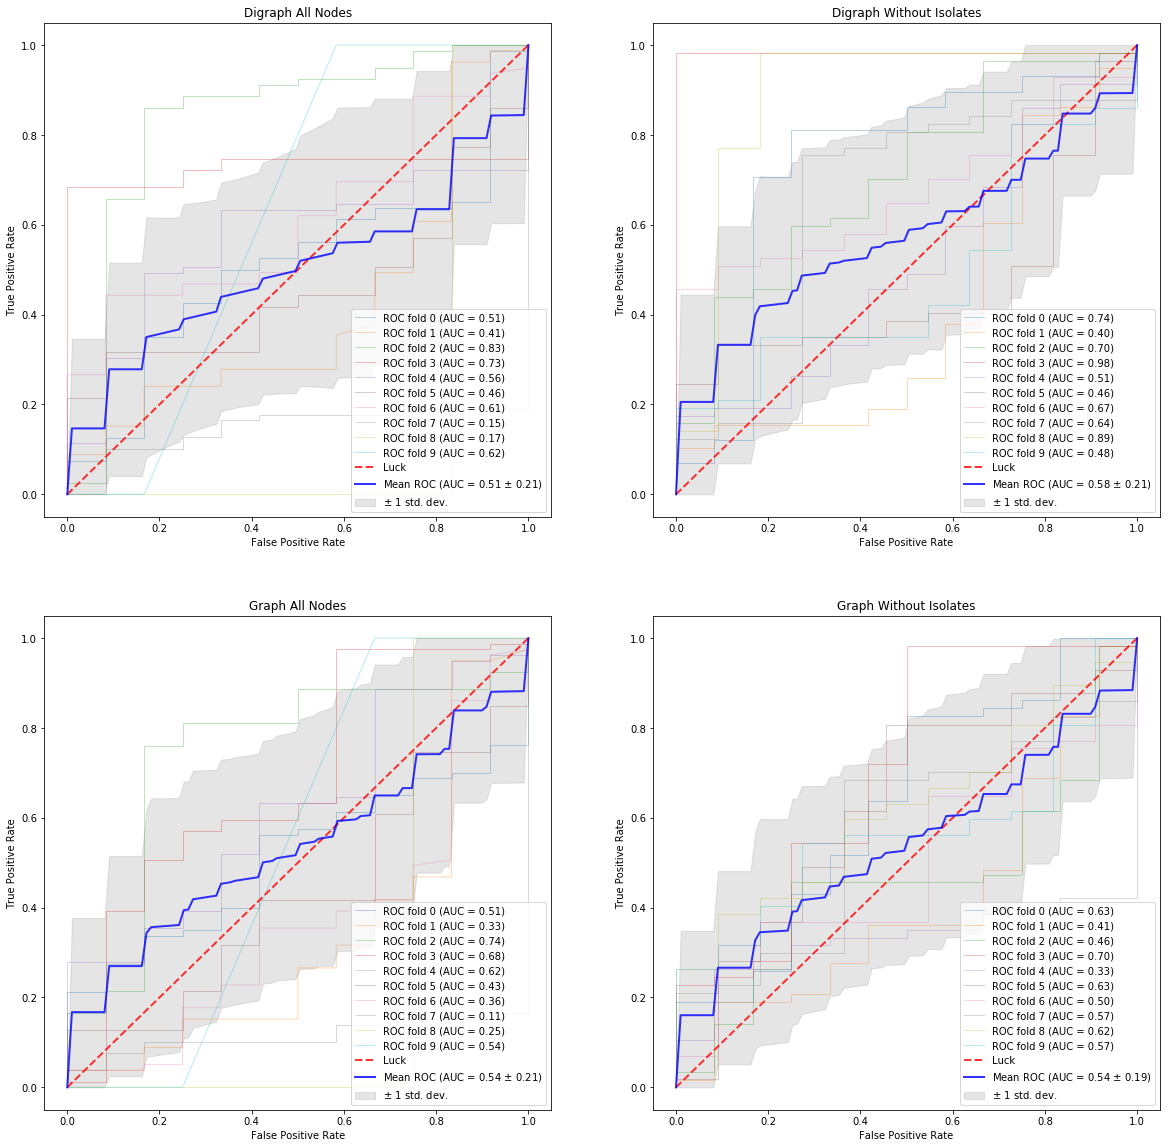

In [6]:
cv = StratifiedKFold(n_splits=10)
classifier = SVC(probability=True)
row=2
col=2
fig = plt.figure(figsize=(20,20))
a = fig.add_subplot(row, col, 1)
s1 = time.time()
imgplot1 = roc(cv, X_dall, y_dall, mean_fpr_dall, aucs_dall,tprs_dall,classifier)
s1 = time.time() - s1
a.set_title('Digraph All Nodes')
#---------------------------------------------------------------------------------
a = fig.add_subplot(row, col, 2)
s2 = time.time()
imgplot2 = roc(cv, X_dwi, y_dwi, mean_fpr_dall, aucs_dall,tprs_dall,classifier)
s2 = time.time() - s2
a.set_title('Digraph Without Isolates')
#---------------------------------------------------------------------------------
a = fig.add_subplot(row, col, 3)
s3 = time.time()
imgplot3 = roc(cv, X_gall, y_gall, mean_fpr_dall, aucs_dall,tprs_dall,classifier)
s3 = time.time() - s3
a.set_title('Graph All Nodes')
#---------------------------------------------------------------------------------
a = fig.add_subplot(row, col, 4)
s4 = time.time()
imgplot4 = roc(cv, X_gwi, y_gwi, mean_fpr_dall, aucs_dall,tprs_dall,classifier)
s4 = time.time() - s4
a.set_title('Graph Without Isolates')
plt.show()

In [7]:
print("Time for machine learning test\n")
print("Dataset1: --- %s seconds ---" % s1)
print("Dataset2: --- %s seconds ---" % s2)
print("Dataset3: --- %s seconds ---" % s3)
print("Dataset4: --- %s seconds ---" % s4)

Time for machine learning test

Dataset1: --- 0.4959220886230469 seconds ---
Dataset2: --- 0.329695463180542 seconds ---
Dataset3: --- 0.43962574005126953 seconds ---
Dataset4: --- 0.35048651695251465 seconds ---


### Random Forest

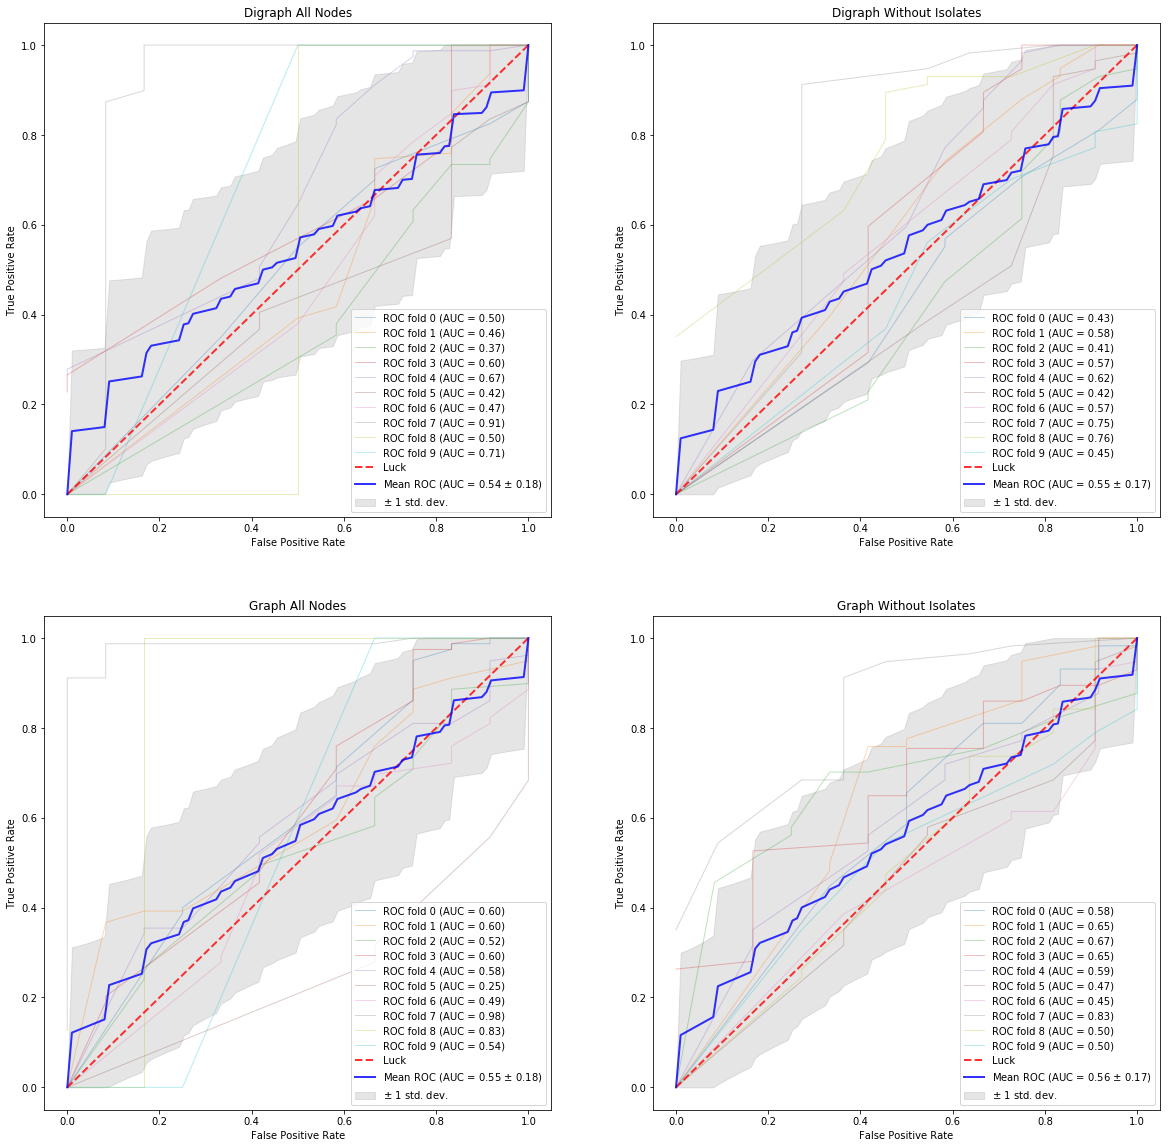

In [8]:
clf = RFC()
row=2
col=2
fig = plt.figure(figsize=(20,20))
a = fig.add_subplot(row, col, 1)
s1 = time.time()
imgplot1 = roc(cv, X_dall, y_dall, mean_fpr_dall, aucs_dall,tprs_dall,clf)
s1 = time.time() - s1
a.set_title('Digraph All Nodes')
#---------------------------------------------------------------------------------
a = fig.add_subplot(row, col, 2)
s2 = time.time()
imgplot2 = roc(cv, X_dwi, y_dwi, mean_fpr_dall, aucs_dall,tprs_dall,clf)
s2 = time.time() - s2
a.set_title('Digraph Without Isolates')
#---------------------------------------------------------------------------------
a = fig.add_subplot(row, col, 3)
s3 = time.time()
imgplot3 = roc(cv, X_gall, y_gall, mean_fpr_dall, aucs_dall,tprs_dall,clf)
s3 = time.time() - s3
a.set_title('Graph All Nodes')
#---------------------------------------------------------------------------------
a = fig.add_subplot(row, col, 4)
s4 = time.time()
imgplot4 = roc(cv, X_gwi, y_gwi, mean_fpr_dall, aucs_dall,tprs_dall,clf)
s4 = time.time() - s4
a.set_title('Graph Without Isolates')
plt.show()

In [9]:
print("Time for machine learning test\n")
print("Dataset1: --- %s seconds ---" % s1)
print("Dataset2: --- %s seconds ---" % s2)
print("Dataset3: --- %s seconds ---" % s3)
print("Dataset4: --- %s seconds ---" % s4)

Time for machine learning test

Dataset1: --- 0.3527977466583252 seconds ---
Dataset2: --- 0.2948496341705322 seconds ---
Dataset3: --- 0.43774890899658203 seconds ---
Dataset4: --- 0.3900134563446045 seconds ---
